First load all the dependencies and set some figure requirements

In [1]:
%pylab inline
import xarray as xr
from tqdm import tqdm_notebook
import cmocean.cm as cmo
import pandas as pd

import my_functions as my
import my_plot_params

Populating the interactive namespace from numpy and matplotlib


In [4]:
argo = xr.open_dataset('../data/Argo/GL_PR_PF_5904397.nc')

In [5]:
argo['LATITUDE'] = (('TIME'), argo.LATITUDE.values)
argo['LONGITUDE'] = (('TIME'), argo.LONGITUDE.values)

In [6]:
argo_subset = argo.sel(TIME=slice(np.datetime64('2018-10-20'), 
                                  np.datetime64('2019-01-01'))
                      ).isel(TIME=[0, 2, 4, 6, 8, 10, 12]
                            )



In [7]:
from scipy.interpolate import griddata

dpt = np.arange(2000)

argo_salt = np.ndarray([len(dpt), len(argo_subset.TIME)])

for i in range(len(argo_subset.TIME)):
    
    argo_salt[:,i] = griddata(argo_subset.PRES[i], argo_subset.PSAL_ADJUSTED[i], dpt)

In [8]:
import gsw

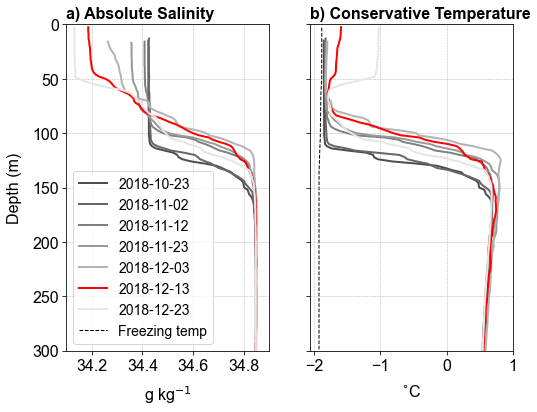

In [21]:
fig,ax=subplots(1,2, figsize=[8, 6], sharey=True)

for i in range(len(argo_subset.TIME)):
    
    c = ['0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', 'k']
    
    sal = gsw.SA_from_SP(argo_subset.PSAL_ADJUSTED[i], 
                         argo_subset.PRES[i]/1000, 
                         argo_subset.LONGITUDE[i], 
                         argo_subset.LATITUDE[i]
                        )
    
    tem = gsw.CT_from_t(sal, 
                        argo_subset.TEMP_ADJUSTED[i],
                        argo_subset.PRES[i]/1000
                        )
    
    freezing_pt = gsw.CT_freezing(sal, argo_subset.PSAL_ADJUSTED[i], 0)

    if i==5:
        ax[0].plot(sal, argo_subset.PRES[i], color='r', label=str(argo_subset.TIME[i].values)[:10], zorder=10, lw=2)
        ax[1].plot(tem, argo_subset.PRES[i], color='r', label=str(argo_subset.TIME[i].values)[:10], zorder=10, lw=2)
    
    else:
        ax[0].plot(sal, argo_subset.PRES[i], color=c[i], label=str(argo_subset.TIME[i].values)[:10], zorder=10, lw=2)
        ax[1].plot(tem, argo_subset.PRES[i], color=c[i], label=str(argo_subset.TIME[i].values)[:10], zorder=10, lw=2)
    
ax[0].plot(freezing_pt, argo_subset.PRES[i], c='k', zorder=0, ls='--', label='Freezing temp', lw=1)
ax[1].plot(freezing_pt, argo_subset.PRES[i], c='k', zorder=0, ls='--', label='Freezing temp', lw=1)

for a in ax:
    
    a.set_ylim(300, 0)

ax[0].legend(loc=3, fontsize=14)
ax[0].set_ylabel('Depth (m)', labelpad=10)

# ax[0].set_title('Argo Float #5904397', fontweight='bold')
# ax[1].set_title(str(argo_subset.LATITUDE.mean().values)[1:6]+'S '+str(argo_subset.LONGITUDE.mean().values)[1:5]+'W', fontweight='bold')

ax[0].set_title('a) Absolute Salinity',        loc='left', fontweight='bold', fontsize=16)
ax[1].set_title('b) Conservative Temperature', loc='left', fontweight='bold', fontsize=16)

ax[1].xaxis.set_ticks([-2, -1, 0, 1])
ax[0].set_xlim(34.1, 34.9)

ax[0].set_xlabel('g kg$^{-1}$', labelpad=10)
ax[1].set_xlabel('$^{\circ}$C', labelpad=10)

ax[0].grid(lw=0.5, ls='--')
ax[1].grid(lw=0.5, ls='--')

savefig('../figs_submission2/fig3.png', dpi=300, bbox_inches='tight')

In [11]:
alpha = gsw.alpha(34.2, -1.5, 0)
beta  = gsw.beta(34.2, -1.5, 0)
h     = 50
rho0  = 1027
Cp    = 3850

dS = argo_subset.PSAL_ADJUSTED[0].min()-argo_subset.PSAL_ADJUSTED[5].min()


print((dS/(51*24*60*60) * (h*(beta/alpha)*rho0*Cp)).values)

278.18704826342133
